In [1]:
import numpy as np
text = "You say goodbye and I say hello."

In [2]:
# 말뭉치를 이용하기 위한 전처리 구현

def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ') # 단어 단위로 분할

  word_to_id = {} # 단어에서 id로 변환하는 딕셔너리
  id_to_word = {} # id에서 단어로 변환하는 딕셔너리
  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  corpus = np.array([word_to_id[w] for w in words]) # 단어 목록에서 id 목록으로 변환한 다음 넘파이배열로 변환
  return corpus, word_to_id, id_to_word

In [3]:
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [4]:
# 동시발생 행렬 구현

def create_co_matrix(corpus, vocab_size, window_size=1):
  corpus_size = len(corpus)
  co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32) # 0으로 채워진 2차원 배열로 초기화

  for idx, word_id in enumerate(corpus):
    for i in range(1, window_size+1):
      left_idx = idx - i # 왼쪽에서 오른쪽으로 이동하기 때문에 왼쪽은 - 오른쪽은 +
      right_idx = idx + i

      if left_idx >= 0:
        left_word_id = corpus[left_idx]
        co_matrix[word_id, left_word_id] += 1 # 윈도우에 포함된 단어일 때 1증가

      if right_idx < corpus_size:
        right_word_id = corpus[right_idx]
        co_matrix[word_id, right_word_id] += 1 # 윈도우에 포함된 단어일 때 1증가

  return co_matrix

In [5]:
# 코사인 유사도 구현

def cos_similarity(x, y, eps=1e-8):
  nx = x / (np.sqrt(np.sum(x**2)) + eps) # x의 정규화 인수가 0일 때 오류가 발생하므로 분모에 작은 값을 더함
  ny = y / (np.sqrt(np.sum(y**2)) + eps) # y의 정규화 인수가 0일 때 오류가 발생하므로 분모에 작은 값을 더함
  return np.dot(nx, ny)

In [6]:
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]

print(cos_similarity(c0, c1))

0.7071067691154799


In [7]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
  if query not in word_to_id:
    print('%s(을)를 찾을 수 없습니다.' % query) # 검색어 추출
    return
  
  print('\n[query]' + query)
  query_id = word_to_id[query]
  query_vec = word_matrix[query_id]

  vocab_size = len(id_to_word)
  similarity = np.zeros(vocab_size)
  for i in range(vocab_size): # 코사인 유사도 계산
    similarity[i] = cos_similarity(word_matrix[i], query_vec)

  count = 0
  for i in (-1 * similarity).argsort(): # 유사도 기준으로 내림차순으로 출력
    if id_to_word[i] == query:
      continue
    print(' %s" %s' % (id_to_word[i], similarity[i]))

    count += 1
    if count >= top:
      return

In [8]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query]you
 goodbye" 0.7071067691154799
 i" 0.7071067691154799
 hello" 0.7071067691154799
 say" 0.0
 and" 0.0


In [9]:
# 양의 상호정보량 구현

def ppmi(C, verbose=False, eps=1e-8):
  M = np.zeros_like(C, dtype=np.float32)
  N = np.sum(C)
  S = np.sum(C, axis=0)
  total = C.shape[0] * C.shape[1]
  cnt = 0

  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      pmi = np.log2(C[i,j] * N / (S[j] * S[i]) + eps) # 동시발생 횟수가 0이면 발산된다는 문제를 해결하기 위해 매우 작은수를 더함
      M[i, j] = max(0,pmi) # PMI가 음수일 때는 0으로 취급

      if verbose:
        cnt += 1
        if cnt % (total//100) == 0:
          print('%.1f%% 완료' % (100*cnt/total))

  return M

In [10]:
W = ppmi(C)
np.set_printoptions(precision=3)
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [11]:
# SVD 구현

U,S,V = np.linalg.svd(W)
print(U[0])

[-1.110e-16  3.409e-01 -4.163e-16 -1.205e-01 -1.110e-16 -9.323e-01
 -1.086e-16]


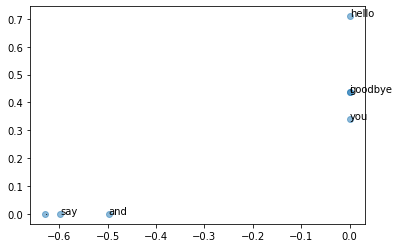

In [12]:
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
  plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

In [16]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch-2.git
import sys, os
sys.path.append('/content/deep-learning-from-scratch-2')
from dataset import ptb

window_size = 2
wordvec_size = 100
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산...')
C = create_co_matrix(corpus, vocab_size, window_size) # 동시발생 행렬계산
print('PPMI 계산...')
W = ppmi(C, verbose=True) # 계산된 행렬 PPMI 계산

print('SVD 계산...')
try:
  from sklearn.utils.extmath import randomized_svd
  U,S,V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None) # 무작위 수를 사용한 Truncated SVD 계산
except ImportError: # import Error가 발생하면 SVD 계산
  U,S,V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']

for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5) # 가장 유사한 5개 출력

fatal: destination path 'deep-learning-from-scratch-2' already exists and is not an empty directory.
Done
동시발생 수 계산...
PPMI 계산...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 